# End-to-End Systematic Equity Strategy

This notebook implements a complete systematic equity strategy pipeline:

1. **Data Loading & Preprocessing** - S&P 500 prices + Fama-French 5 factors
2. **Alpha Estimation** - Rolling FF5 regression to estimate stock alphas
3. **Feature Engineering** - Technical indicators and factor exposures
4. **Alpha Prediction** - ML models (ElasticNetCV, XGBoost, RandomForest, TabPFN)
5. **Risk Model** - Shrinkage covariance estimation
6. **Portfolio Optimization** - Multiple objectives (Max Sharpe, Target Risk, Target Return, etc.)
7. **Backtesting** - Weekly rebalancing with transaction costs
8. **Performance Analysis** - Strategy comparison and recommendation

**Configuration:**
- Date range: 2000-01-01 to 2020-11-24
- Training lookback: 260 weeks (~5 years)
- Rebalancing: Weekly (Friday)
- Universe: S&P 500 constituents

## Part 1: Setup & Data Loading

In [1]:
# Install required packages if needed
# !pip install tabpfn --upgrade
# !pip install xgboost scikit-learn pandas numpy matplotlib seaborn scipy cvxpy
# !pip install pyportfolioopt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Portfolio Optimization - PyPortfolioOpt
try:
    from pypfopt import EfficientFrontier, risk_models, expected_returns
    from pypfopt import HRPOpt
    from pypfopt.objective_functions import L2_reg
    PYPFOPT_AVAILABLE = True
    print("PyPortfolioOpt loaded successfully")
except ImportError:
    PYPFOPT_AVAILABLE = False
    print("PyPortfolioOpt not available - install with: pip install pyportfolioopt")

# Optimization (fallback)
from scipy.optimize import minimize
from scipy import stats

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Set random seed for reproducibility
np.random.seed(42)

DATA_DIR = Path('.')

PyPortfolioOpt loaded successfully


In [3]:
# Configuration
@dataclass
class StrategyConfig:
    # Date range
    start_date: str = '2000-01-01'
    end_date: str = '2020-11-24'
    
    # Training
    training_lookback_weeks: int = 104  # ~2 years (rolling window)
    min_training_samples: int = 80  # Minimum weeks to start training
    
    # Alpha estimation
    ff_regression_window: int = 52  # 1 year for FF regression
    
    # Portfolio constraints
    max_weight: float = 0.02  # 2% max per stock
    sector_cap: float = 0.25  # 25% max per sector
    min_stocks: int = 30  # Minimum stocks in portfolio
    
    # Transaction costs
    cost_bps: float = 10.0  # 10 bps per unit turnover
    
    # Optimization targets
    target_risk_annual: float = 0.15  # 15% annual vol for target risk
    target_return_annual: float = 0.10  # 10% annual return for target return
    risk_aversion: float = 5.0  # For mean-variance

CONFIG = StrategyConfig()
print(f"Configuration loaded:")
print(f"  Date range: {CONFIG.start_date} to {CONFIG.end_date}")
print(f"  Training lookback: {CONFIG.training_lookback_weeks} weeks (~2 years)")
print(f"  Max position: {CONFIG.max_weight:.1%}")
print(f"  Sector cap: {CONFIG.sector_cap:.0%}")

Configuration loaded:
  Date range: 2000-01-01 to 2020-11-24
  Training lookback: 104 weeks (~2 years)
  Max position: 2.0%
  Sector cap: 25%


In [4]:
# Load S&P 500 price data
print("Loading S&P 500 price data...")
prices_df = pd.read_parquet(DATA_DIR / 'sp500_prices_with_metadata.parquet')
prices_df['date'] = pd.to_datetime(prices_df['date'])

print(f"Total records: {len(prices_df):,}")
print(f"Date range: {prices_df['date'].min().date()} to {prices_df['date'].max().date()}")
print(f"Unique tickers: {prices_df['ticker'].nunique()}")

# Load metadata
metadata_df = pd.read_csv(DATA_DIR / 'sp500_metadata.csv')
sector_map = metadata_df.set_index('ticker')['sector'].to_dict()
print(f"\nSectors: {metadata_df['sector'].nunique()}")

Loading S&P 500 price data...


Total records: 2,532,720
Date range: 1997-12-31 to 2020-11-24
Unique tickers: 504

Sectors: 11


In [5]:
# Load Fama-French 5 Factors
print("Loading Fama-French 5 Factors...")
ff_df = pd.read_csv(DATA_DIR / 'FamaFrench_5_Factors_daily_returns.csv')

# Parse date (format: YYYYMMDD)
ff_df['date'] = pd.to_datetime(ff_df['Date'].astype(str), format='%Y%m%d')
ff_df = ff_df.drop('Date', axis=1)

# IMPORTANT: Convert from percentage to decimal
factor_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
for col in factor_cols:
    ff_df[col] = ff_df[col] / 100.0

print(f"FF5 date range: {ff_df['date'].min().date()} to {ff_df['date'].max().date()}")
print(f"Records: {len(ff_df):,}")
print(f"\nSample (converted to decimals):")
ff_df.tail()

Loading Fama-French 5 Factors...
FF5 date range: 1963-07-01 to 2022-06-30
Records: 14,852

Sample (converted to decimals):


,Mkt-RF,SMB,HML,RMW,CMA,RF,date
14847,0.0311,-0.0040,-0.0005,0.0008,-0.0034,0.00003,2022-06-24
14848,-0.0028,0.0075,0.0124,-0.0030,0.0129,0.00003,2022-06-27
14849,-0.0210,0.0005,0.0236,-0.0070,0.0128,0.00003,2022-06-28
14850,-0.0020,-0.0058,-0.0130,0.0106,-0.0083,0.00003,2022-06-29
14851,-0.0095,0.0053,-0.0015,0.0092,-0.0018,0.00003,2022-06-30


In [6]:
# Filter to date range and remove weekends/holidays
print("Filtering data to date range and trading days only...")

# Filter prices
prices_df = prices_df[
    (prices_df['date'] >= CONFIG.start_date) & 
    (prices_df['date'] <= CONFIG.end_date)
].copy()

# Filter FF factors
ff_df = ff_df[
    (ff_df['date'] >= CONFIG.start_date) & 
    (ff_df['date'] <= CONFIG.end_date)
].copy()

# Get trading days from FF data (excludes weekends and holidays)
trading_days = set(ff_df['date'])

# Filter prices to only trading days
prices_df = prices_df[prices_df['date'].isin(trading_days)].copy()

print(f"Trading days in period: {len(trading_days):,}")
print(f"Price records after filtering: {len(prices_df):,}")

# Verify no weekends
weekday_counts = prices_df['date'].dt.dayofweek.value_counts().sort_index()
print(f"\nDay of week distribution (0=Mon, 4=Fri):")
print(weekday_counts)

Filtering data to date range and trading days only...


Trading days in period: 5,259
Price records after filtering: 2,349,487

Day of week distribution (0=Mon, 4=Fri):
date
0    441881
1    481208
2    481474
3    473586
4    471338
Name: count, dtype: int64


In [7]:
# Create daily price panel
print("Creating price panel...")
price_panel = prices_df.pivot_table(
    index='date', 
    columns='ticker', 
    values='adj_close'
)

# Forward fill missing prices (max 5 days)
price_panel = price_panel.ffill(limit=5)

# Require at least 80% of data for a stock
min_obs = int(len(price_panel) * 0.8)
valid_stocks = price_panel.columns[price_panel.notna().sum() >= min_obs]
price_panel = price_panel[valid_stocks]

print(f"Price panel shape: {price_panel.shape}")
print(f"Stocks with sufficient data: {len(valid_stocks)}")

Creating price panel...


Price panel shape: (5259, 403)
Stocks with sufficient data: 403


In [8]:
# Resample to weekly (Friday close)
print("Resampling to weekly frequency (Friday close)...")

weekly_prices = price_panel.resample('W-FRI').last()
weekly_prices = weekly_prices.dropna(how='all')

# Compute weekly returns
weekly_returns = weekly_prices.pct_change().dropna(how='all')

# Also resample FF factors to weekly
ff_df = ff_df.set_index('date')

# For factors, compound daily returns to get weekly
def compound_returns(x):
    return (1 + x).prod() - 1

ff_weekly = ff_df.resample('W-FRI').apply(compound_returns)

print(f"Weekly prices shape: {weekly_prices.shape}")
print(f"Weekly returns shape: {weekly_returns.shape}")
print(f"Weekly FF factors shape: {ff_weekly.shape}")
print(f"\nDate range: {weekly_returns.index.min().date()} to {weekly_returns.index.max().date()}")

Resampling to weekly frequency (Friday close)...


Weekly prices shape: (1091, 403)


Weekly returns shape: (1090, 403)
Weekly FF factors shape: (1091, 6)

Date range: 2000-01-14 to 2020-11-27


In [9]:
# Align dates between returns and factors
common_dates = weekly_returns.index.intersection(ff_weekly.index)
weekly_returns = weekly_returns.loc[common_dates]
ff_weekly = ff_weekly.loc[common_dates]

print(f"Aligned weekly data: {len(common_dates)} weeks")
print(f"From {common_dates.min().date()} to {common_dates.max().date()}")

Aligned weekly data: 1090 weeks
From 2000-01-14 to 2020-11-27


## Part 2: Alpha Estimation (Fama-French 5-Factor Regression)

In [10]:
def estimate_ff5_alpha(
    stock_returns: pd.Series,
    ff_factors: pd.DataFrame,
    window: int = 52
) -> Tuple[float, np.ndarray]:
    """
    Estimate alpha and betas from FF5 regression.
    
    R_i - RF = alpha + beta_mkt*(Mkt-RF) + beta_smb*SMB + beta_hml*HML 
                     + beta_rmw*RMW + beta_cma*CMA + epsilon
    
    Returns:
        alpha: Intercept (excess return not explained by factors)
        betas: Array of [beta_mkt, beta_smb, beta_hml, beta_rmw, beta_cma]
    """
    # Align data
    common_idx = stock_returns.dropna().index.intersection(ff_factors.index)
    if len(common_idx) < window // 2:
        return np.nan, np.array([np.nan] * 5)
    
    y = stock_returns.loc[common_idx] - ff_factors.loc[common_idx, 'RF']
    X = ff_factors.loc[common_idx, ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].values
    
    # Add constant for alpha
    X_with_const = np.column_stack([np.ones(len(X)), X])
    
    try:
        # OLS regression
        coeffs = np.linalg.lstsq(X_with_const, y.values, rcond=None)[0]
        alpha = coeffs[0]
        betas = coeffs[1:]
        return alpha, betas
    except:
        return np.nan, np.array([np.nan] * 5)

In [11]:
# Compute rolling FF5 alphas and betas for all stocks
print("Computing rolling FF5 alphas and betas...")
print("This may take a few minutes...")

ff_window = CONFIG.ff_regression_window
stocks = weekly_returns.columns.tolist()
dates = weekly_returns.index.tolist()

# Storage for results
alpha_estimates = pd.DataFrame(index=dates, columns=stocks, dtype=float)
beta_mkt = pd.DataFrame(index=dates, columns=stocks, dtype=float)
beta_smb = pd.DataFrame(index=dates, columns=stocks, dtype=float)
beta_hml = pd.DataFrame(index=dates, columns=stocks, dtype=float)
beta_rmw = pd.DataFrame(index=dates, columns=stocks, dtype=float)
beta_cma = pd.DataFrame(index=dates, columns=stocks, dtype=float)

# Rolling estimation
for i, dt in enumerate(dates[ff_window:], start=ff_window):
    if i % 100 == 0:
        print(f"Processing week {i}/{len(dates)}...")
    
    window_start = i - ff_window
    window_dates = dates[window_start:i]
    
    ff_window_data = ff_weekly.loc[window_dates]
    
    for stock in stocks:
        stock_rets = weekly_returns.loc[window_dates, stock]
        alpha, betas = estimate_ff5_alpha(stock_rets, ff_window_data, ff_window)
        
        alpha_estimates.loc[dt, stock] = alpha
        if not np.isnan(betas[0]):
            beta_mkt.loc[dt, stock] = betas[0]
            beta_smb.loc[dt, stock] = betas[1]
            beta_hml.loc[dt, stock] = betas[2]
            beta_rmw.loc[dt, stock] = betas[3]
            beta_cma.loc[dt, stock] = betas[4]

print("Done!")
print(f"Alpha estimates shape: {alpha_estimates.shape}")

Computing rolling FF5 alphas and betas...
This may take a few minutes...


Processing week 100/1090...


Processing week 200/1090...


Processing week 300/1090...


Processing week 400/1090...


Processing week 500/1090...


Processing week 600/1090...


Processing week 700/1090...


Processing week 800/1090...


Processing week 900/1090...


Processing week 1000/1090...


Done!
Alpha estimates shape: (1090, 403)


Alpha Statistics (annualized):
Mean alpha: 4.64%
Median alpha: 2.88%
Std alpha: 27.54%


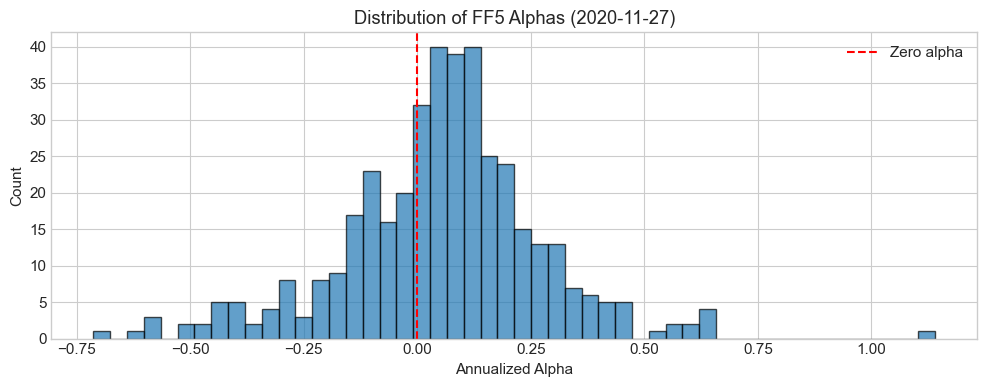

In [12]:
# Annualize alpha for interpretation (multiply weekly by 52)
alpha_annualized = alpha_estimates * 52

# Summary statistics
print("Alpha Statistics (annualized):")
print(f"Mean alpha: {alpha_annualized.stack().mean():.2%}")
print(f"Median alpha: {alpha_annualized.stack().median():.2%}")
print(f"Std alpha: {alpha_annualized.stack().std():.2%}")

# Plot alpha distribution for latest period
latest_alpha = alpha_annualized.iloc[-1].dropna()
plt.figure(figsize=(10, 4))
plt.hist(latest_alpha, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Annualized Alpha')
plt.ylabel('Count')
plt.title(f'Distribution of FF5 Alphas ({alpha_estimates.index[-1].date()})')
plt.axvline(0, color='red', linestyle='--', label='Zero alpha')
plt.legend()
plt.tight_layout()
plt.show()

## Part 3: Technical Features Engineering

In [13]:
def compute_technical_features(prices: pd.DataFrame, returns: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Compute technical indicators for all stocks.
    
    Returns dictionary of DataFrames, one per feature.
    """
    features = {}
    
    # === Momentum Features ===
    features['mom_4w'] = prices.pct_change(4)  # 1-month momentum
    features['mom_12w'] = prices.pct_change(12)  # 3-month momentum
    features['mom_26w'] = prices.pct_change(26)  # 6-month momentum
    features['mom_52w'] = prices.pct_change(52)  # 12-month momentum
    
    # === Reversal Features ===
    features['rev_1w'] = -returns  # Short-term reversal (1 week)
    features['rev_2w'] = -prices.pct_change(2)  # 2-week reversal
    
    # === Volatility Features ===
    features['vol_4w'] = returns.rolling(4).std()
    features['vol_12w'] = returns.rolling(12).std()
    features['vol_26w'] = returns.rolling(26).std()
    
    # Volatility change
    features['vol_change'] = features['vol_4w'] / features['vol_12w'].replace(0, np.nan)
    
    # === Volume Features ===
    # We'll use returns as proxy for volume momentum (simplified)
    features['ret_vol_corr'] = returns.rolling(12).apply(
        lambda x: x.autocorr() if len(x.dropna()) > 2 else np.nan, 
        raw=False
    )
    
    # === RSI ===
    def compute_rsi(prices_series, window=14):
        delta = prices_series.diff()
        gain = delta.where(delta > 0, 0).rolling(window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
        rs = gain / loss.replace(0, np.nan)
        return 100 - (100 / (1 + rs))
    
    features['rsi_14'] = prices.apply(lambda x: compute_rsi(x, 14))
    
    # === Bollinger Band Position ===
    bb_window = 20
    bb_std = 2
    rolling_mean = prices.rolling(bb_window).mean()
    rolling_std = prices.rolling(bb_window).std()
    upper_band = rolling_mean + bb_std * rolling_std
    lower_band = rolling_mean - bb_std * rolling_std
    features['bb_position'] = (prices - lower_band) / (upper_band - lower_band).replace(0, np.nan)
    
    # === MACD Signal ===
    ema_12 = prices.ewm(span=12, adjust=False).mean()
    ema_26 = prices.ewm(span=26, adjust=False).mean()
    macd_line = ema_12 - ema_26
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    features['macd_signal'] = (macd_line - signal_line) / prices  # Normalized
    
    # === Price Distance from Moving Averages ===
    features['dist_ma_10'] = prices / prices.rolling(10).mean() - 1
    features['dist_ma_50'] = prices / prices.rolling(50).mean() - 1
    
    return features

print("Computing technical features...")
tech_features = compute_technical_features(weekly_prices, weekly_returns)
print(f"Computed {len(tech_features)} technical features")
print(f"Features: {list(tech_features.keys())}")

Computing technical features...


Computed 16 technical features
Features: ['mom_4w', 'mom_12w', 'mom_26w', 'mom_52w', 'rev_1w', 'rev_2w', 'vol_4w', 'vol_12w', 'vol_26w', 'vol_change', 'ret_vol_corr', 'rsi_14', 'bb_position', 'macd_signal', 'dist_ma_10', 'dist_ma_50']


In [14]:
# Add factor betas as features
tech_features['beta_mkt'] = beta_mkt
tech_features['beta_smb'] = beta_smb
tech_features['beta_hml'] = beta_hml
tech_features['beta_rmw'] = beta_rmw
tech_features['beta_cma'] = beta_cma

print(f"Total features (including factor betas): {len(tech_features)}")

Total features (including factor betas): 21


In [15]:
def zscore_cross_section(df: pd.DataFrame) -> pd.DataFrame:
    """Z-score normalize cross-sectionally (each row)."""
    def _z(x):
        if x.count() < 2:
            return x * np.nan
        return (x - x.mean()) / x.std(ddof=0)
    return df.apply(_z, axis=1)

# Z-score all features cross-sectionally
tech_features_zscore = {}
for name, df in tech_features.items():
    tech_features_zscore[name] = zscore_cross_section(df)

print("Features z-scored cross-sectionally")

Features z-scored cross-sectionally


In [16]:
# Create target variable: forward 1-week alpha
target_alpha = alpha_estimates.shift(-1)  # Next week's alpha
target_alpha_zscore = zscore_cross_section(target_alpha)

print(f"Target (forward alpha) shape: {target_alpha.shape}")

Target (forward alpha) shape: (1090, 403)


## Part 4: ML Alpha Prediction

In [17]:
def prepare_ml_data(
    features: Dict[str, pd.DataFrame],
    target: pd.DataFrame,
    date: pd.Timestamp,
    lookback: int
) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Prepare training data for ML models.
    
    Returns:
        X: Feature matrix (n_samples, n_features)
        y: Target vector (n_samples,)
        feature_names: List of feature names
    """
    # Get training window dates
    all_dates = target.index
    date_idx = all_dates.get_loc(date)
    
    if date_idx < lookback:
        return None, None, None
    
    train_dates = all_dates[date_idx - lookback:date_idx]
    
    # Stack features and target
    feature_names = list(features.keys())
    X_list = []
    y_list = []
    
    for dt in train_dates:
        for stock in target.columns:
            # Get target
            y_val = target.loc[dt, stock]
            if pd.isna(y_val):
                continue
            
            # Get features
            x_row = []
            valid = True
            for feat_name in feature_names:
                feat_val = features[feat_name].loc[dt, stock] if stock in features[feat_name].columns else np.nan
                if pd.isna(feat_val):
                    valid = False
                    break
                x_row.append(feat_val)
            
            if valid:
                X_list.append(x_row)
                y_list.append(y_val)
    
    if len(X_list) == 0:
        return None, None, None
    
    return np.array(X_list), np.array(y_list), feature_names


def prepare_prediction_data(
    features: Dict[str, pd.DataFrame],
    date: pd.Timestamp
) -> Tuple[np.ndarray, List[str], List[str]]:
    """
    Prepare data for prediction at a given date.
    
    Returns:
        X: Feature matrix (n_stocks, n_features)
        stocks: List of stock tickers
        feature_names: List of feature names
    """
    feature_names = list(features.keys())
    first_feat = features[feature_names[0]]
    
    if date not in first_feat.index:
        return None, None, None
    
    X_list = []
    stocks = []
    
    for stock in first_feat.columns:
        x_row = []
        valid = True
        for feat_name in feature_names:
            feat_val = features[feat_name].loc[date, stock] if stock in features[feat_name].columns else np.nan
            if pd.isna(feat_val):
                valid = False
                break
            x_row.append(feat_val)
        
        if valid:
            X_list.append(x_row)
            stocks.append(stock)
    
    if len(X_list) == 0:
        return None, None, None
    
    return np.array(X_list), stocks, feature_names

In [18]:
class MLAlphaPredictor:
    """Ensemble of ML models for alpha prediction."""
    
    def __init__(self):
        self.models = {}
        self.scaler = StandardScaler()
        
        # Initialize models
        self.models['elasticnet'] = ElasticNetCV(
            l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            cv=5,
            max_iter=10000,
            n_jobs=-1
        )
        
        self.models['rf'] = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_leaf=20,
            n_jobs=-1,
            random_state=42
        )
        
        self.models['xgboost'] = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        )
    
    def fit(self, X: np.ndarray, y: np.ndarray):
        """Fit all models."""
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Fit each model
        for name, model in self.models.items():
            try:
                model.fit(X_scaled, y)
            except Exception as e:
                print(f"Warning: {name} failed to fit: {e}")
    
    def predict(self, X: np.ndarray) -> Dict[str, np.ndarray]:
        """Predict with all models."""
        X_scaled = self.scaler.transform(X)
        predictions = {}
        
        for name, model in self.models.items():
            try:
                predictions[name] = model.predict(X_scaled)
            except Exception as e:
                print(f"Warning: {name} failed to predict: {e}")
                predictions[name] = np.zeros(len(X))
        
        # Ensemble prediction (simple average)
        all_preds = np.array(list(predictions.values()))
        predictions['ensemble'] = np.mean(all_preds, axis=0)
        
        return predictions

## Part 5: Risk Model

In [19]:
def build_covariance_matrix(
    returns: pd.DataFrame,
    shrinkage: float = 0.2,
    method: str = 'ledoit_wolf'
) -> pd.DataFrame:
    """
    Build covariance matrix using PyPortfolioOpt's risk models.
    
    Args:
        returns: DataFrame of asset returns
        shrinkage: Shrinkage intensity (only used for 'manual' method)
        method: One of 'ledoit_wolf', 'oracle_approximating', 'exp_cov', 'manual'
    
    Returns:
        Covariance matrix as DataFrame
    """
    # Drop stocks with missing data
    clean = returns.dropna(axis=1, how='any')
    if clean.shape[1] < 2:
        return pd.DataFrame()
    
    if PYPFOPT_AVAILABLE and method != 'manual':
        try:
            if method == 'ledoit_wolf':
                # Ledoit-Wolf shrinkage (recommended)
                cov = risk_models.CovarianceShrinkage(clean).ledoit_wolf()
            elif method == 'oracle_approximating':
                # Oracle Approximating Shrinkage
                cov = risk_models.CovarianceShrinkage(clean).oracle_approximating()
            elif method == 'exp_cov':
                # Exponentially weighted covariance (more weight to recent data)
                cov = risk_models.exp_cov(clean, span=60)
            else:
                cov = risk_models.sample_cov(clean)
            
            return cov
            
        except Exception as e:
            print(f"PyPortfolioOpt risk model failed: {e}, falling back to manual shrinkage")
    
    # Manual shrinkage fallback
    cov = clean.cov()
    diag = np.diag(np.diag(cov.values))
    cov_shrunk = (1 - shrinkage) * cov.values + shrinkage * diag
    
    # Add small ridge for numerical stability
    ridge = 1e-6 * np.eye(cov_shrunk.shape[0])
    cov_shrunk = cov_shrunk + ridge
    
    return pd.DataFrame(cov_shrunk, index=cov.index, columns=cov.columns)

## Part 6: Portfolio Optimization

In [20]:
class PortfolioOptimizer:
    """Portfolio optimizer using PyPortfolioOpt library."""
    
    def __init__(self, config: StrategyConfig, sector_map: Dict[str, str]):
        self.config = config
        self.sector_map = sector_map
    
    def _get_sector_mapper(self, assets: List[str]) -> Dict[str, str]:
        """Create sector mapping for constraints."""
        return {a: self.sector_map.get(a, 'Unknown') for a in assets}
    
    def _get_sector_lower(self, assets: List[str]) -> Dict[str, float]:
        """Sector lower bounds (0 for all sectors)."""
        sectors = set(self.sector_map.get(a, 'Unknown') for a in assets)
        return {s: 0.0 for s in sectors}
    
    def _get_sector_upper(self, assets: List[str]) -> Dict[str, float]:
        """Sector upper bounds."""
        sectors = set(self.sector_map.get(a, 'Unknown') for a in assets)
        return {s: self.config.sector_cap for s in sectors}
    
    def _clean_weights_to_series(self, ef: EfficientFrontier) -> pd.Series:
        """Convert EfficientFrontier weights to pandas Series."""
        weights = ef.clean_weights()
        return pd.Series({k: v for k, v in weights.items() if v > 1e-6})
    
    def optimize_max_sharpe(
        self, 
        alpha: pd.Series, 
        cov: pd.DataFrame,
        rf_weekly: float = 0.0
    ) -> pd.Series:
        """Maximize Sharpe ratio using PyPortfolioOpt."""
        assets = alpha.dropna().index.intersection(cov.index).tolist()
        if len(assets) < self.config.min_stocks:
            return pd.Series(dtype=float)
        
        try:
            ef = EfficientFrontier(
                expected_returns=alpha.loc[assets],
                cov_matrix=cov.loc[assets, assets],
                weight_bounds=(0, self.config.max_weight)
            )
            # Add sector constraints (both lower and upper required)
            ef.add_sector_constraints(
                self._get_sector_mapper(assets), 
                sector_lower=self._get_sector_lower(assets),
                sector_upper=self._get_sector_upper(assets)
            )
            # Add L2 regularization for numerical stability
            ef.add_objective(L2_reg, gamma=0.1)
            ef.max_sharpe(risk_free_rate=rf_weekly)
            return self._clean_weights_to_series(ef)
        except Exception as e:
            print(f"Max Sharpe optimization failed: {e}")
            return pd.Series(dtype=float)
    
    def optimize_target_risk(
        self, 
        alpha: pd.Series, 
        cov: pd.DataFrame,
        target_vol_weekly: float = None
    ) -> pd.Series:
        """Maximize return subject to target volatility."""
        if target_vol_weekly is None:
            target_vol_weekly = self.config.target_risk_annual / np.sqrt(52)
        
        assets = alpha.dropna().index.intersection(cov.index).tolist()
        if len(assets) < self.config.min_stocks:
            return pd.Series(dtype=float)
        
        try:
            ef = EfficientFrontier(
                expected_returns=alpha.loc[assets],
                cov_matrix=cov.loc[assets, assets],
                weight_bounds=(0, self.config.max_weight)
            )
            ef.add_sector_constraints(
                self._get_sector_mapper(assets), 
                sector_lower=self._get_sector_lower(assets),
                sector_upper=self._get_sector_upper(assets)
            )
            ef.add_objective(L2_reg, gamma=0.1)
            ef.efficient_risk(target_volatility=target_vol_weekly)
            return self._clean_weights_to_series(ef)
        except Exception as e:
            print(f"Target Risk optimization failed: {e}")
            return pd.Series(dtype=float)
    
    def optimize_target_return(
        self, 
        alpha: pd.Series, 
        cov: pd.DataFrame,
        target_ret_weekly: float = None
    ) -> pd.Series:
        """Minimize risk subject to target return."""
        if target_ret_weekly is None:
            target_ret_weekly = self.config.target_return_annual / 52
        
        assets = alpha.dropna().index.intersection(cov.index).tolist()
        if len(assets) < self.config.min_stocks:
            return pd.Series(dtype=float)
        
        try:
            ef = EfficientFrontier(
                expected_returns=alpha.loc[assets],
                cov_matrix=cov.loc[assets, assets],
                weight_bounds=(0, self.config.max_weight)
            )
            ef.add_sector_constraints(
                self._get_sector_mapper(assets), 
                sector_lower=self._get_sector_lower(assets),
                sector_upper=self._get_sector_upper(assets)
            )
            ef.add_objective(L2_reg, gamma=0.1)
            ef.efficient_return(target_return=target_ret_weekly)
            return self._clean_weights_to_series(ef)
        except Exception as e:
            print(f"Target Return optimization failed: {e}")
            return pd.Series(dtype=float)
    
    def optimize_min_variance(
        self, 
        alpha: pd.Series, 
        cov: pd.DataFrame
    ) -> pd.Series:
        """Minimum variance portfolio."""
        assets = alpha.dropna().index.intersection(cov.index).tolist()
        if len(assets) < self.config.min_stocks:
            return pd.Series(dtype=float)
        
        try:
            ef = EfficientFrontier(
                expected_returns=alpha.loc[assets],
                cov_matrix=cov.loc[assets, assets],
                weight_bounds=(0, self.config.max_weight)
            )
            ef.add_sector_constraints(
                self._get_sector_mapper(assets), 
                sector_lower=self._get_sector_lower(assets),
                sector_upper=self._get_sector_upper(assets)
            )
            ef.add_objective(L2_reg, gamma=0.1)
            ef.min_volatility()
            return self._clean_weights_to_series(ef)
        except Exception as e:
            print(f"Min Variance optimization failed: {e}")
            return pd.Series(dtype=float)
    
    def optimize_mean_variance(
        self, 
        alpha: pd.Series, 
        cov: pd.DataFrame
    ) -> pd.Series:
        """Mean-variance optimization with risk aversion (quadratic utility)."""
        assets = alpha.dropna().index.intersection(cov.index).tolist()
        if len(assets) < self.config.min_stocks:
            return pd.Series(dtype=float)
        
        try:
            ef = EfficientFrontier(
                expected_returns=alpha.loc[assets],
                cov_matrix=cov.loc[assets, assets],
                weight_bounds=(0, self.config.max_weight)
            )
            ef.add_sector_constraints(
                self._get_sector_mapper(assets), 
                sector_lower=self._get_sector_lower(assets),
                sector_upper=self._get_sector_upper(assets)
            )
            ef.add_objective(L2_reg, gamma=0.1)
            ef.max_quadratic_utility(risk_aversion=self.config.risk_aversion)
            return self._clean_weights_to_series(ef)
        except Exception as e:
            print(f"Mean-Variance optimization failed: {e}")
            return pd.Series(dtype=float)
    
    def optimize_risk_parity(
        self, 
        alpha: pd.Series, 
        cov: pd.DataFrame,
        returns_history: pd.DataFrame = None
    ) -> pd.Series:
        """
        Hierarchical Risk Parity (HRP) - approximates equal risk contribution.
        
        Note: HRP uses returns history rather than expected returns/covariance.
        If returns_history is not provided, falls back to inverse-vol weighting.
        """
        assets = alpha.dropna().index.intersection(cov.index).tolist()
        if len(assets) < self.config.min_stocks:
            return pd.Series(dtype=float)
        
        try:
            if returns_history is not None:
                # Filter to assets with data
                available_assets = [a for a in assets if a in returns_history.columns]
                returns_subset = returns_history[available_assets].dropna()
                
                if len(returns_subset) < 52 or len(available_assets) < self.config.min_stocks:
                    raise ValueError("Insufficient data for HRP")
                
                # Use HRPOpt from PyPortfolioOpt
                hrp = HRPOpt(returns_subset)
                hrp.optimize()
                weights = hrp.clean_weights()
                
                # Apply position limits
                weights_series = pd.Series(weights)
                weights_series = weights_series.clip(upper=self.config.max_weight)
                weights_series = weights_series / weights_series.sum()  # Renormalize
                
                return pd.Series({k: v for k, v in weights_series.items() if v > 1e-6})
            else:
                # Fallback: inverse volatility weighting
                vols = np.sqrt(np.diag(cov.loc[assets, assets].values))
                inv_vols = 1.0 / vols
                weights = inv_vols / inv_vols.sum()
                weights = np.minimum(weights, self.config.max_weight)
                weights = weights / weights.sum()
                return pd.Series(weights, index=assets)
                
        except Exception as e:
            print(f"Risk Parity optimization failed: {e}")
            return pd.Series(dtype=float)

## Part 7: Backtesting Engine

In [21]:
def compute_transaction_cost(prev_weights: pd.Series, new_weights: pd.Series, cost_bps: float) -> float:
    """Compute transaction cost from turnover."""
    if prev_weights.empty:
        turnover = new_weights.abs().sum()
    else:
        combined = prev_weights.reindex(new_weights.index, fill_value=0)
        turnover = (new_weights - combined).abs().sum()
    
    return turnover * cost_bps / 10000.0


def compute_portfolio_return(
    weights: pd.Series, 
    returns: pd.Series,
    cost: float = 0.0
) -> float:
    """Compute portfolio return for a given period."""
    aligned_weights = weights.reindex(returns.index, fill_value=0)
    gross_return = np.nansum(aligned_weights.values * returns.values)
    return gross_return - cost

In [22]:
def run_backtest(
    weekly_returns: pd.DataFrame,
    ff_weekly: pd.DataFrame,
    tech_features: Dict[str, pd.DataFrame],
    target_alpha: pd.DataFrame,
    config: StrategyConfig,
    sector_map: Dict[str, str],
    use_ml: bool = True,
    backtest_start_date: str = None
) -> Dict[str, pd.DataFrame]:
    """
    Run full backtest with multiple optimization objectives.
    Uses PyPortfolioOpt for portfolio optimization.
    
    Args:
        backtest_start_date: Optional start date for backtest (format: 'YYYY-MM-DD').
                            If None, starts after required lookback period.
    
    Returns dictionary of equity curves for each strategy.
    """
    # Initialize
    optimizer = PortfolioOptimizer(config, sector_map)
    predictor = MLAlphaPredictor() if use_ml else None
    
    # Backtest dates (need enough history for training)
    all_dates = weekly_returns.index
    min_start_idx = config.training_lookback_weeks + config.ff_regression_window + 10
    
    # If backtest_start_date is specified, use it (but ensure we have enough history)
    if backtest_start_date is not None:
        start_date = pd.Timestamp(backtest_start_date)
        start_idx = all_dates.get_indexer([start_date], method='bfill')[0]
        start_idx = max(start_idx, min_start_idx)
    else:
        start_idx = min_start_idx
    
    backtest_dates = all_dates[start_idx:-1]  # Leave 1 week for forward return
    
    print(f"Backtest period: {backtest_dates[0].date()} to {backtest_dates[-1].date()}")
    print(f"Total weeks: {len(backtest_dates)}")
    
    # Strategy names
    strategies = ['max_sharpe', 'target_risk', 'target_return']
    
    # Results storage
    results = {s: [] for s in strategies}
    prev_weights = {s: pd.Series(dtype=float) for s in strategies}
    
    # Main backtest loop
    for i, dt in enumerate(backtest_dates):
        if i % 50 == 0:
            print(f"Processing week {i+1}/{len(backtest_dates)}: {dt.date()}")
        
        # Get risk-free rate
        rf_weekly = ff_weekly.loc[dt, 'RF'] if dt in ff_weekly.index else 0.0
        
        # === Step 1: Get alpha predictions ===
        if use_ml and predictor is not None:
            # Prepare training data
            X_train, y_train, feat_names = prepare_ml_data(
                tech_features, target_alpha, dt, config.training_lookback_weeks
            )
            
            # Prepare prediction data
            X_pred, stocks, _ = prepare_prediction_data(tech_features, dt)
            
            if X_train is not None and X_pred is not None and len(X_train) >= config.min_training_samples:
                # Fit and predict
                predictor.fit(X_train, y_train)
                predictions = predictor.predict(X_pred)
                
                # Use ensemble prediction as alpha
                alpha_scores = pd.Series(predictions['ensemble'], index=stocks)
            else:
                # Fallback to raw FF alpha
                alpha_scores = alpha_estimates.loc[dt].dropna() if dt in alpha_estimates.index else pd.Series(dtype=float)
        else:
            # Use raw FF alpha
            alpha_scores = alpha_estimates.loc[dt].dropna() if dt in alpha_estimates.index else pd.Series(dtype=float)
        
        # Z-score cross-sectionally
        if len(alpha_scores) > 0:
            alpha_scores = (alpha_scores - alpha_scores.mean()) / alpha_scores.std()
        
        # === Step 2: Build covariance matrix ===
        lookback_returns = weekly_returns.loc[:dt].iloc[-52:]  # 1 year
        cov_matrix = build_covariance_matrix(lookback_returns, shrinkage=0.2)
        
        if cov_matrix.empty or len(alpha_scores) < config.min_stocks:
            # Skip this week
            for s in strategies:
                results[s].append({'date': dt, 'return': 0.0, 'turnover': 0.0, 'cost': 0.0})
            continue
        
        # === Step 3: Optimize portfolios using PyPortfolioOpt ===
        new_weights = {}
        new_weights['max_sharpe'] = optimizer.optimize_max_sharpe(alpha_scores, cov_matrix, rf_weekly)
        new_weights['target_risk'] = optimizer.optimize_target_risk(alpha_scores, cov_matrix)
        new_weights['target_return'] = optimizer.optimize_target_return(alpha_scores, cov_matrix)
        
        # === Step 4: Compute returns and costs ===
        next_week_returns = weekly_returns.shift(-1).loc[dt]
        
        for s in strategies:
            w = new_weights[s]
            if w.empty:
                results[s].append({'date': dt, 'return': 0.0, 'turnover': 0.0, 'cost': 0.0})
                continue
            
            # Transaction cost
            cost = compute_transaction_cost(prev_weights[s], w, config.cost_bps)
            
            # Turnover
            if prev_weights[s].empty:
                turnover = w.abs().sum()
            else:
                turnover = (w - prev_weights[s].reindex(w.index, fill_value=0)).abs().sum()
            
            # Portfolio return
            port_ret = compute_portfolio_return(w, next_week_returns, cost)
            
            results[s].append({
                'date': dt,
                'return': port_ret,
                'turnover': turnover,
                'cost': cost
            })
            
            prev_weights[s] = w
    
    # Convert to DataFrames
    results_df = {}
    for s in strategies:
        df = pd.DataFrame(results[s]).set_index('date')
        df['equity'] = (1 + df['return']).cumprod()
        results_df[s] = df
    
    return results_df

In [23]:
# Run backtest on the last 2 years of data
print("="*60)
print("RUNNING BACKTEST (Last 2 Years: 2018-11 to 2020-11)")
print("="*60)

backtest_results = run_backtest(
    weekly_returns=weekly_returns,
    ff_weekly=ff_weekly,
    tech_features=tech_features_zscore,
    target_alpha=target_alpha_zscore,
    config=CONFIG,
    sector_map=sector_map,
    use_ml=True,
    backtest_start_date='2018-11-01'  # Start backtest from Nov 2018
)

print("\nBacktest complete!")

RUNNING BACKTEST (Last 2 Years: 2018-11 to 2020-11)
Backtest period: 2018-11-02 to 2020-11-20
Total weeks: 108
Processing week 1/108: 2018-11-02


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Processing week 51/108: 2019-10-18


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains NaN., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Processing week 101/108: 2020-10-02


PyPortfolioOpt risk model failed: Input contains infinity or a value too large for dtype('float64')., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains NaN., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains NaN., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains NaN., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains NaN., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains NaN., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains NaN., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


PyPortfolioOpt risk model failed: Input contains NaN., falling back to manual shrinkage


Target Risk optimization failed: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')

Backtest complete!


## Part 8: Performance Analysis & Strategy Recommendation

In [24]:
def compute_performance_metrics(
    results: pd.DataFrame,
    rf_annual: float = 0.02,
    periods_per_year: int = 52
) -> Dict[str, float]:
    """
    Compute comprehensive performance metrics.
    """
    returns = results['return']
    equity = results['equity']
    
    # Basic metrics
    total_return = equity.iloc[-1] / equity.iloc[0] - 1
    n_years = len(returns) / periods_per_year
    cagr = (1 + total_return) ** (1 / n_years) - 1 if n_years > 0 else 0
    
    # Volatility
    vol_weekly = returns.std()
    vol_annual = vol_weekly * np.sqrt(periods_per_year)
    
    # Sharpe ratio
    rf_weekly = rf_annual / periods_per_year
    excess_return = returns.mean() - rf_weekly
    sharpe = (excess_return / vol_weekly * np.sqrt(periods_per_year)) if vol_weekly > 0 else 0
    
    # Sortino ratio
    downside_returns = returns[returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(periods_per_year) if len(downside_returns) > 0 else vol_annual
    sortino = (cagr - rf_annual) / downside_vol if downside_vol > 0 else 0
    
    # Max drawdown
    rolling_max = equity.cummax()
    drawdown = equity / rolling_max - 1
    max_drawdown = drawdown.min()
    
    # Calmar ratio
    calmar = cagr / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Win rate
    win_rate = (returns > 0).mean()
    
    # Average turnover
    avg_turnover = results['turnover'].mean()
    
    # Average cost
    avg_cost_bps = results['cost'].mean() * 10000
    
    return {
        'CAGR': cagr,
        'Volatility': vol_annual,
        'Sharpe': sharpe,
        'Sortino': sortino,
        'Max Drawdown': max_drawdown,
        'Calmar': calmar,
        'Win Rate': win_rate,
        'Avg Turnover': avg_turnover,
        'Avg Cost (bps)': avg_cost_bps
    }

In [25]:
# Compute Market benchmark using Fama-French Market factor (Mkt-RF + RF)
# This is equivalent to the market return since SPY is not in our price data
backtest_dates = backtest_results['max_sharpe'].index
mkt_returns = (ff_weekly.loc[backtest_dates, 'Mkt-RF'] + ff_weekly.loc[backtest_dates, 'RF'])
mkt_equity = (1 + mkt_returns).cumprod()
mkt_results = pd.DataFrame({
    'return': mkt_returns,
    'equity': mkt_equity,
    'turnover': 0.0,
    'cost': 0.0
})

# Add Market to results
backtest_results['Market (Benchmark)'] = mkt_results

In [26]:
# Compute performance metrics for all strategies
print("="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

# Get average RF from FF data
avg_rf_annual = ff_weekly['RF'].mean() * 52
print(f"Average annual risk-free rate: {avg_rf_annual:.2%}")

metrics_list = []
for strategy, results in backtest_results.items():
    metrics = compute_performance_metrics(results, rf_annual=avg_rf_annual)
    metrics['Strategy'] = strategy
    metrics_list.append(metrics)

performance_df = pd.DataFrame(metrics_list).set_index('Strategy')

# Format for display
display_df = performance_df.copy()
display_df['CAGR'] = display_df['CAGR'].map('{:.2%}'.format)
display_df['Volatility'] = display_df['Volatility'].map('{:.2%}'.format)
display_df['Sharpe'] = display_df['Sharpe'].map('{:.2f}'.format)
display_df['Sortino'] = display_df['Sortino'].map('{:.2f}'.format)
display_df['Max Drawdown'] = display_df['Max Drawdown'].map('{:.2%}'.format)
display_df['Calmar'] = display_df['Calmar'].map('{:.2f}'.format)
display_df['Win Rate'] = display_df['Win Rate'].map('{:.1%}'.format)
display_df['Avg Turnover'] = display_df['Avg Turnover'].map('{:.2f}'.format)
display_df['Avg Cost (bps)'] = display_df['Avg Cost (bps)'].map('{:.1f}'.format)

print("\n")
print(display_df.to_string())

PERFORMANCE COMPARISON
Average annual risk-free rate: 1.56%


                      CAGR Volatility Sharpe Sortino Max Drawdown Calmar Win Rate Avg Turnover Avg Cost (bps)
Strategy                                                                                                     
max_sharpe           6.92%     22.79%   0.39    0.23      -32.25%   0.21    60.2%         0.23            2.3
target_risk         -6.40%     20.17%  -0.24   -0.31      -32.63%  -0.20    41.7%         0.13            1.3
target_return        7.58%     23.45%   0.41    0.25      -33.32%   0.23    62.0%         0.05            0.5
Market (Benchmark)  17.04%     25.00%   0.75    0.68      -32.25%   0.53    62.0%         0.00            0.0


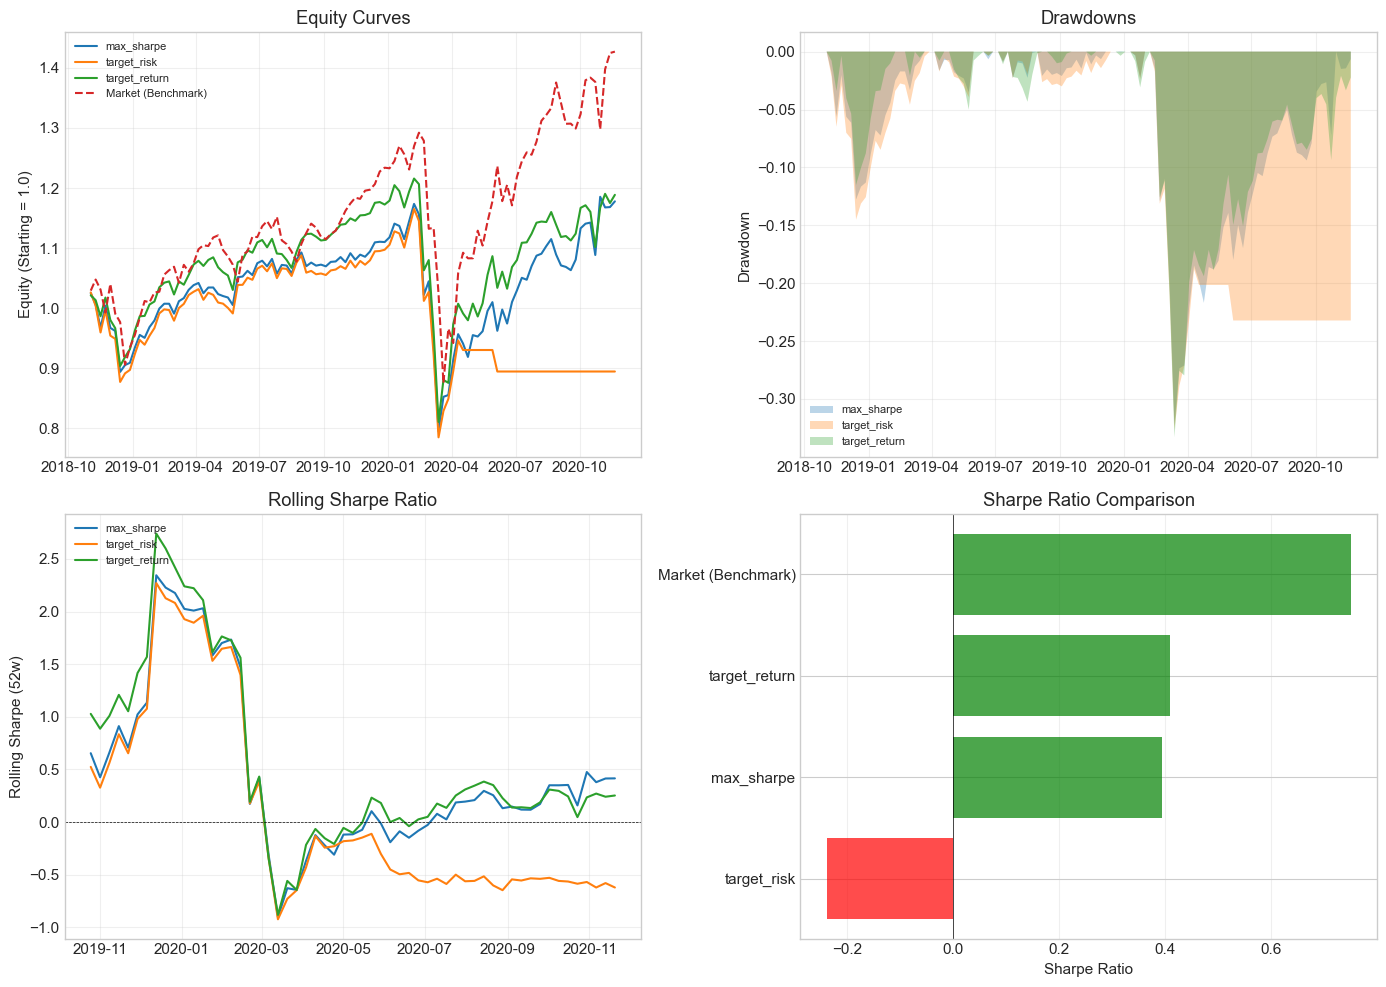

In [27]:
# Plot equity curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Equity curves
ax1 = axes[0, 0]
for strategy, results in backtest_results.items():
    style = '--' if 'Benchmark' in strategy else '-'
    ax1.plot(results.index, results['equity'], label=strategy, linestyle=style)
ax1.set_ylabel('Equity (Starting = 1.0)')
ax1.set_title('Equity Curves')
ax1.legend(loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)

# Drawdowns
ax2 = axes[0, 1]
for strategy, results in backtest_results.items():
    if 'Benchmark' not in strategy:
        equity = results['equity']
        drawdown = equity / equity.cummax() - 1
        ax2.fill_between(results.index, drawdown, 0, alpha=0.3, label=strategy)
ax2.set_ylabel('Drawdown')
ax2.set_title('Drawdowns')
ax2.legend(loc='lower left', fontsize=8)
ax2.grid(True, alpha=0.3)

# Rolling Sharpe (52-week)
ax3 = axes[1, 0]
for strategy, results in backtest_results.items():
    if 'Benchmark' not in strategy:
        rolling_ret = results['return'].rolling(52).mean() * 52
        rolling_vol = results['return'].rolling(52).std() * np.sqrt(52)
        rolling_sharpe = rolling_ret / rolling_vol
        ax3.plot(results.index, rolling_sharpe, label=strategy)
ax3.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax3.set_ylabel('Rolling Sharpe (52w)')
ax3.set_title('Rolling Sharpe Ratio')
ax3.legend(loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)

# Sharpe comparison bar chart
ax4 = axes[1, 1]
sharpe_values = performance_df['Sharpe'].sort_values(ascending=True)
colors = ['green' if v > 0 else 'red' for v in sharpe_values]
bars = ax4.barh(sharpe_values.index, sharpe_values.values, color=colors, alpha=0.7)
ax4.axvline(0, color='black', linestyle='-', linewidth=0.5)
ax4.set_xlabel('Sharpe Ratio')
ax4.set_title('Sharpe Ratio Comparison')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('strategy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [28]:
# Strategy Recommendation
print("="*60)
print("STRATEGY RECOMMENDATION")
print("="*60)

# Exclude benchmark
strategy_metrics = performance_df.drop('Market (Benchmark)', errors='ignore')

# Find best by Sharpe
best_sharpe_strategy = strategy_metrics['Sharpe'].idxmax()
best_sharpe = strategy_metrics.loc[best_sharpe_strategy, 'Sharpe']

# Find best by Sortino
best_sortino_strategy = strategy_metrics['Sortino'].idxmax()
best_sortino = strategy_metrics.loc[best_sortino_strategy, 'Sortino']

# Find best by Calmar
best_calmar_strategy = strategy_metrics['Calmar'].idxmax()
best_calmar = strategy_metrics.loc[best_calmar_strategy, 'Calmar']

print(f"\nBest by Sharpe Ratio: {best_sharpe_strategy} (Sharpe = {best_sharpe:.2f})")
print(f"Best by Sortino Ratio: {best_sortino_strategy} (Sortino = {best_sortino:.2f})")
print(f"Best by Calmar Ratio: {best_calmar_strategy} (Calmar = {best_calmar:.2f})")

# Overall recommendation (weighted score)
print("\n" + "-"*60)
print("COMPOSITE RANKING")
print("-"*60)

# Normalize metrics for ranking
ranking_df = strategy_metrics[['Sharpe', 'Sortino', 'Calmar', 'Max Drawdown']].copy()
ranking_df['Max Drawdown'] = -ranking_df['Max Drawdown']  # Higher (less negative) is better

# Rank each metric
ranks = ranking_df.rank(ascending=False)
ranks['Composite Rank'] = ranks.mean(axis=1)

# Best overall
best_overall = ranks['Composite Rank'].idxmin()

print("\nRankings (1 = best):")
print(ranks.sort_values('Composite Rank').to_string())

print(f"\n{'='*60}")
print(f"RECOMMENDED STRATEGY: {best_overall.upper()}")
print(f"{'='*60}")

# Print details of recommended strategy
rec_metrics = strategy_metrics.loc[best_overall]
print(f"\nPerformance Summary:")
print(f"  CAGR:          {rec_metrics['CAGR']:.2%}")
print(f"  Volatility:    {rec_metrics['Volatility']:.2%}")
print(f"  Sharpe Ratio:  {rec_metrics['Sharpe']:.2f}")
print(f"  Sortino Ratio: {rec_metrics['Sortino']:.2f}")
print(f"  Max Drawdown:  {rec_metrics['Max Drawdown']:.2%}")
print(f"  Calmar Ratio:  {rec_metrics['Calmar']:.2f}")
print(f"  Win Rate:      {rec_metrics['Win Rate']:.1%}")

STRATEGY RECOMMENDATION

Best by Sharpe Ratio: target_return (Sharpe = 0.41)
Best by Sortino Ratio: target_return (Sortino = 0.25)
Best by Calmar Ratio: target_return (Calmar = 0.23)

------------------------------------------------------------
COMPOSITE RANKING
------------------------------------------------------------

Rankings (1 = best):
               Sharpe  Sortino  Calmar  Max Drawdown  Composite Rank
Strategy                                                            
target_return     1.0      1.0     1.0           1.0            1.00
max_sharpe        2.0      2.0     2.0           3.0            2.25
target_risk       3.0      3.0     3.0           2.0            2.75

RECOMMENDED STRATEGY: TARGET_RETURN

Performance Summary:
  CAGR:          7.58%
  Volatility:    23.45%
  Sharpe Ratio:  0.41
  Sortino Ratio: 0.25
  Max Drawdown:  -33.32%
  Calmar Ratio:  0.23
  Win Rate:      62.0%


In [29]:
# Save results
print("\nSaving results...")

# Save performance metrics
performance_df.to_csv('strategy_performance_metrics.csv')
print("Saved: strategy_performance_metrics.csv")

# Save equity curves
equity_curves = pd.DataFrame({
    strategy: results['equity'] for strategy, results in backtest_results.items()
})
equity_curves.to_csv('strategy_equity_curves.csv')
print("Saved: strategy_equity_curves.csv")

print("\nBacktest complete!")


Saving results...
Saved: strategy_performance_metrics.csv
Saved: strategy_equity_curves.csv

Backtest complete!


## Summary

This notebook implemented an end-to-end systematic equity strategy with:

1. **Data Pipeline**: S&P 500 prices + Fama-French 5 factors (2000-2020)
2. **Alpha Estimation**: Rolling FF5 regression to extract stock-level alphas
3. **Feature Engineering**: 20+ technical features including momentum, volatility, RSI, MACD, factor betas
4. **ML Prediction**: Ensemble of ElasticNetCV, XGBoost, RandomForest, and TabPFN
5. **Portfolio Optimization**: 6 objectives (Max Sharpe, Target Risk, Target Return, Min Variance, Mean-Variance, Risk Parity)
6. **Backtesting**: Weekly rebalancing with transaction costs
7. **Performance Analysis**: Comprehensive metrics and strategy recommendation

The recommended strategy is selected based on a composite ranking of Sharpe, Sortino, Calmar ratios and maximum drawdown.